In [1]:
import pandas as pd
from scipy.stats import f_oneway
from datetime import datetime, timedelta,date
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division
import sklearn
from sklearn.cluster import KMeans
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import warnings
warnings.filterwarnings("ignore")
from tabulate import tabulate
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

C:\Users\rsk29\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


<div class="alert alert-info">1. Quartile split and segmentation</div>

In [7]:
# Load the data from the CSV file
df_og = pd.read_csv("OG_dataset.csv")
df = pd.read_csv("OG_dataset.csv")

# Calculate RFM variables
df.rename(columns={'history': 'monetary_value'}, inplace=True)
df.rename(columns={'recency_segment': 'r_segment'}, inplace=True)

df

,recency,r_segment,monetary_value,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,4,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,2,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,3,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,3,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
63995,10,4,105.54,1,0,Urban,0,Web,Mens E-Mail,0,0,0.0
63996,5,2,38.91,0,1,Urban,1,Phone,Mens E-Mail,0,0,0.0
63997,6,2,29.99,1,0,Urban,1,Phone,Mens E-Mail,0,0,0.0
63998,1,1,552.94,1,0,Surburban,1,Multichannel,Womens E-Mail,0,0,0.0


In [8]:
# Sort the DataFrame by monetary_value
df_sorted = df.sort_values('monetary_value')

# Calculate the total sum of monetary_value for the full dataset and divide by 4
total_sum = df_sorted['monetary_value'].sum()
segment_sum = total_sum / 4

# Initialize variables for segment count and cumulative sum
segment_count = 1
cumulative_sum = 0

# Iterate through the DataFrame to assign segments
for index, row in df_sorted.iterrows():
    cumulative_sum += row['monetary_value']
    if cumulative_sum > segment_sum and segment_count < 4:
        cumulative_sum = 0
        segment_count += 1
    df_sorted.at[index, 'm_segment'] = segment_count

# Print the DataFrame to verify the changes
df_sorted

,recency,r_segment,monetary_value,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,m_segment
13273,8,3,29.99,1,0,Urban,0,Web,Mens E-Mail,0,0,0.0,1.0
37838,10,4,29.99,0,1,Surburban,0,Phone,No E-Mail,0,0,0.0,1.0
16956,7,3,29.99,1,0,Urban,1,Phone,No E-Mail,0,0,0.0,1.0
57486,6,2,29.99,1,0,Urban,1,Phone,Mens E-Mail,0,0,0.0,1.0
37836,3,1,29.99,0,1,Surburban,1,Phone,Mens E-Mail,0,0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46493,1,1,2895.11,1,1,Urban,1,Multichannel,Mens E-Mail,0,0,0.0,4.0
43060,1,1,3003.48,1,1,Urban,1,Phone,No E-Mail,0,0,0.0,4.0
52860,1,1,3040.20,0,1,Urban,1,Web,Womens E-Mail,0,0,0.0,4.0
38680,1,1,3215.97,1,1,Urban,1,Multichannel,Mens E-Mail,1,0,0.0,4.0


In [9]:
df_sorted['m_segment'] = df_sorted['m_segment'].astype(int)

In [10]:
# RFM Segmentation
df_sorted['RM_Segment'] = df_sorted.apply(lambda row: str(row['r_segment']) + str(row['m_segment']), axis=1)

In [11]:
df_sorted

,recency,r_segment,monetary_value,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,m_segment,RM_Segment
13273,8,3,29.99,1,0,Urban,0,Web,Mens E-Mail,0,0,0.0,1,31
37838,10,4,29.99,0,1,Surburban,0,Phone,No E-Mail,0,0,0.0,1,41
16956,7,3,29.99,1,0,Urban,1,Phone,No E-Mail,0,0,0.0,1,31
57486,6,2,29.99,1,0,Urban,1,Phone,Mens E-Mail,0,0,0.0,1,21
37836,3,1,29.99,0,1,Surburban,1,Phone,Mens E-Mail,0,0,0.0,1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46493,1,1,2895.11,1,1,Urban,1,Multichannel,Mens E-Mail,0,0,0.0,4,14
43060,1,1,3003.48,1,1,Urban,1,Phone,No E-Mail,0,0,0.0,4,14
52860,1,1,3040.20,0,1,Urban,1,Web,Womens E-Mail,0,0,0.0,4,14
38680,1,1,3215.97,1,1,Urban,1,Multichannel,Mens E-Mail,1,0,0.0,4,14


In [18]:
def calc_summary(df, group_column):
    rm_segment_summary = df.groupby(group_column).agg({
        'RM_Segment': 'count',
        'monetary_value': ['min', 'max', 'mean'],
    })

    # Average conversion
    average_conversion = df.groupby(group_column)['visit'].mean()

    # Rename the columns for clarity
    rm_segment_summary.columns = ['Count', 'Min Monetary Value', 'Max Monetary Value', 'Average Monetary Value']
    rm_segment_summary['Average Conversion'] = average_conversion

    # Round the values to two decimal places
    rm_segment_summary = rm_segment_summary.round(2)
    
    return rm_segment_summary

In [28]:
# Function for calculating the uplift
def calc_uplift(df):
    
    ### AVERAGE ORDER VALUE?
    avg_order_value = 25
    
    # Calculate conversions for each offer type
    base_conv = df[df.segment == 'No E-Mail']['visit'].mean()
    disc_conv = df[df.segment == 'Mens E-Mail']['visit'].mean()
    bogo_conv = df[df.segment == 'Womens E-Mail']['visit'].mean()
    
    print(base_conv)
    print(disc_conv)
    print(bogo_conv)
    
    # Calculate conversion uplift for discount and bogo
    disc_conv_uplift = disc_conv - base_conv
    bogo_conv_uplift = bogo_conv - base_conv
    
    # Calculate order uplift
    disc_order_uplift = disc_conv_uplift * len(df[df.segment == 'Mens E-Mail']['visit'])
    bogo_order_uplift = bogo_conv_uplift * len(df[df.segment == 'Womens E-Mail']['visit'])
    
    # Calculate revenue uplift
    disc_rev_uplift = disc_order_uplift * avg_order_value
    bogo_rev_uplift = bogo_order_uplift * avg_order_value
    
    print(disc_rev_uplift)
    print(bogo_rev_uplift)
    
    if len(df[df.segment == 'Mens E-Mail']['visit']) > 0:
        table1 = [
            ["Mens Total Targeted Customer Count", np.round(len(df[df.segment == 'Mens E-Mail']))],
            ["Mens Conversion Uplift (%)", np.round(disc_conv_uplift*100,2)],
            ["Mens Order Uplift", np.round(disc_order_uplift,2)],
            ["Mens Revenue Uplift", np.round(disc_rev_uplift,2)],
            ["Mens Revenue Uplift Per Targeted Customer", np.round((disc_rev_uplift/len(df[df.segment == 'Mens E-Mail'])),2)]
        ]
        print(tabulate(table1, headers=["MENS Metrics", "Values"]))
    
    print('\n')
    
    if len(df[df.segment == 'Womens E-Mail']['visit']) > 0:
        table2 = [
            ["Womens Total Targeted Customer Count", np.round(len(df[df.segment == 'Womens E-Mail']))],
            ["Womens Conversion Uplift (%)", np.round(bogo_conv_uplift*100,2)],
            ["Womens Order Uplift", np.round(bogo_order_uplift,2)],
            ["Womens Revenue Uplift", np.round(bogo_rev_uplift,2)],
            ["Womens Revenue Uplift Per Targeted Customer", np.round((bogo_rev_uplift/len(df[df.segment == 'Womens E-Mail'])),2)]
        ]
        print(tabulate(table2, headers=["WoMENS Metrics", "Values"]))
        
    print('\n\n')

In [14]:
calc_uplift(df_sorted)

MENS Metrics                                 Values
-----------------------------------------  --------
Mens Total Targeted Customer Count         21307
Mens Conversion Uplift (%)                     7.66
Mens Order Uplift                           1631.89
Mens Revenue Uplift                        40797.3
Mens Revenue Uplift Per Targeted Customer      1.91


WoMENS Metrics                                 Values
-------------------------------------------  --------
Womens Total Targeted Customer Count         21387
Womens Conversion Uplift (%)                     4.52
Womens Order Uplift                            967.4
Womens Revenue Uplift                        24185
Womens Revenue Uplift Per Targeted Customer      1.13





<div class="alert alert-info">1.1 ANOVA test between the RM segments</div>

In [15]:
# Perform ANOVA between segments
anova_results = {}
for segment in df_sorted['RM_Segment'].unique():
    data = [df_sorted[df_sorted['RM_Segment'] == segment]['visit'],
            df_sorted[df_sorted['RM_Segment'] != segment]['visit']]  # Adding a second array for comparison
    anova_results[segment] = f_oneway(*data)

# Print ANOVA results for each segment, sorted by key
sorted_anova_results = dict(sorted(anova_results.items()))
for segment, result in sorted_anova_results.items():
    print(f"ANOVA results for segment {segment}:")
    print(result)
    print()

ANOVA results for segment 11:
F_onewayResult(statistic=15.612219739337855, pvalue=7.783385258402932e-05)

ANOVA results for segment 12:
F_onewayResult(statistic=144.9020105051973, pvalue=2.4515502900509405e-33)

ANOVA results for segment 13:
F_onewayResult(statistic=66.9961064079454, pvalue=2.769964120647465e-16)

ANOVA results for segment 14:
F_onewayResult(statistic=99.55693505523445, pvalue=1.9827430830304875e-23)

ANOVA results for segment 21:
F_onewayResult(statistic=23.55657954920718, pvalue=1.215791126851498e-06)

ANOVA results for segment 22:
F_onewayResult(statistic=9.617391227232698, pvalue=0.0019282707062590965)

ANOVA results for segment 23:
F_onewayResult(statistic=6.682254132519147, pvalue=0.009739931636712872)

ANOVA results for segment 24:
F_onewayResult(statistic=3.556041933667556, pvalue=0.0593335742533864)

ANOVA results for segment 31:
F_onewayResult(statistic=122.40967006368548, pvalue=1.9926622326235626e-28)

ANOVA results for segment 32:
F_onewayResult(statistic=

In [16]:
# Analysis and Strategy Development
df_rm = df_sorted.groupby(['r_segment', 'm_segment']).agg({'visit': 'mean'}).unstack()

# Convert average conversion to percentage
df_rm = df_rm.apply(lambda x: round(x * 100,2))

# Display as percentages
df_rm.index = ['R1', 'R2', 'R3', 'R4']
df_rm.columns = ['M1', 'M2', 'M3', 'M4']

df_rm

,M1,M2,M3,M4
R1,15.86,20.58,19.42,21.44
R2,12.99,16.68,16.86,17.08
R3,11.03,16.02,13.88,14.72
R4,10.52,14.47,16.21,20.10


<div class="alert alert-info">1.2 Output metrics to compare RM segments</div>

In [19]:
rm_segment_summary = calc_summary(df_sorted, 'RM_Segment')
rm_segment_summary

,Count,Min Monetary Value,Max Monetary Value,Average Monetary Value,Average Conversion
RM_Segment,,,,,
11,11442,29.99,225.77,102.91,0.16
12,4811,225.79,412.85,308.74,0.21
13,3528,413.00,686.93,531.01,0.19
14,2612,687.51,3345.93,1014.36,0.21
21,8864,29.99,225.68,96.58,0.13
22,2859,225.89,412.76,308.57,0.17
23,1708,412.95,686.76,523.40,0.17
24,761,687.08,2583.84,920.99,0.17
31,9731,29.99,225.77,94.88,0.11


In [20]:
for i in np.sort(df_sorted['RM_Segment'].unique()):
    print(f'RM Segment {i}:\n')
    calc_uplift(df_sorted[df_sorted['RM_Segment'] == i])

RM Segment 11:

MENS Metrics                                 Values
-----------------------------------------  --------
Mens Total Targeted Customer Count          3829
Mens Conversion Uplift (%)                     7.62
Mens Order Uplift                            291.75
Mens Revenue Uplift                         7293.81
Mens Revenue Uplift Per Targeted Customer      1.9


WoMENS Metrics                                 Values
-------------------------------------------  --------
Womens Total Targeted Customer Count          3761
Womens Conversion Uplift (%)                     4.09
Womens Order Uplift                            153.89
Womens Revenue Uplift                         3847.27
Womens Revenue Uplift Per Targeted Customer      1.02



RM Segment 12:

MENS Metrics                                 Values
-----------------------------------------  --------
Mens Total Targeted Customer Count          1575
Mens Conversion Uplift (%)                     9.72
Mens Order Uplift      

MENS Metrics                                 Values
-----------------------------------------  --------
Mens Total Targeted Customer Count           287
Mens Conversion Uplift (%)                    10.21
Mens Order Uplift                             29.31
Mens Revenue Uplift                          732.76
Mens Revenue Uplift Per Targeted Customer      2.55


WoMENS Metrics                                 Values
-------------------------------------------  --------
Womens Total Targeted Customer Count           305
Womens Conversion Uplift (%)                     7.36
Womens Order Uplift                             22.45
Womens Revenue Uplift                          561.21
Womens Revenue Uplift Per Targeted Customer      1.84



RM Segment 44:

MENS Metrics                                 Values
-----------------------------------------  --------
Mens Total Targeted Customer Count            77
Mens Conversion Uplift (%)                     6.73
Mens Order Uplift                     

<div class="alert alert-info">2. Responder segments for Uplift calculation</div>

In [21]:
df_sorted['campaign_group'] = 'treatment'
df_sorted.loc[df_sorted.segment == 'No E-Mail', 'campaign_group'] = 'control'

### 01 - CN - Control Non-responders
### 02 - CR - Control Responders
### 03 - TN - Test Non-responders
### 04 - TR - Test Responders

df_sorted['Responder_Segment'] = 0 #CN
df_sorted.loc[(df_sorted.campaign_group == 'control') & (df_sorted.visit > 0),'Responder_Segment'] = 1 #CR
df_sorted.loc[(df_sorted.campaign_group == 'treatment') & (df_sorted.visit == 0),'Responder_Segment'] = 2 #TN
df_sorted.loc[(df_sorted.campaign_group == 'treatment') & (df_sorted.visit > 0),'Responder_Segment'] = 3 #TR

df_sorted

,recency,r_segment,monetary_value,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,m_segment,RM_Segment,campaign_group,Responder_Segment
13273,8,3,29.99,1,0,Urban,0,Web,Mens E-Mail,0,0,0.0,1,31,treatment,2
37838,10,4,29.99,0,1,Surburban,0,Phone,No E-Mail,0,0,0.0,1,41,control,0
16956,7,3,29.99,1,0,Urban,1,Phone,No E-Mail,0,0,0.0,1,31,control,0
57486,6,2,29.99,1,0,Urban,1,Phone,Mens E-Mail,0,0,0.0,1,21,treatment,2
37836,3,1,29.99,0,1,Surburban,1,Phone,Mens E-Mail,0,0,0.0,1,11,treatment,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46493,1,1,2895.11,1,1,Urban,1,Multichannel,Mens E-Mail,0,0,0.0,4,14,treatment,2
43060,1,1,3003.48,1,1,Urban,1,Phone,No E-Mail,0,0,0.0,4,14,control,0
52860,1,1,3040.20,0,1,Urban,1,Web,Womens E-Mail,0,0,0.0,4,14,treatment,2
38680,1,1,3215.97,1,1,Urban,1,Multichannel,Mens E-Mail,1,0,0.0,4,14,treatment,3


In [24]:
df_sorted.to_csv(r'C:\Users\rsk29\Documents\UT\Fall\Marketing\Marketing Project\QC.csv')

<div class="alert alert-info">2.1 Output metrics to compare Responder segments</div>

In [22]:
responder_segment_summary = calc_summary(df_sorted, 'Responder_Segment')
responder_segment_summary

,Count,Min Monetary Value,Max Monetary Value,Average Monetary Value,Average Conversion
Responder_Segment,,,,,
0,19044,29.99,3345.93,235.23,0.0
1,2262,29.99,1927.91,288.48,1.0
2,35562,29.99,3040.20,235.13,0.0
3,7132,29.99,3215.97,280.37,1.0


In [29]:
for i in np.sort(df_sorted['Responder_Segment'].unique()):
    print(f'Responder Segment {i}:\n')
    calc_uplift(df_sorted[df_sorted['Responder_Segment'] == i])

Responder Segment 0:

0.0
nan
nan
nan
nan





Responder Segment 1:

1.0
nan
nan
nan
nan





Responder Segment 2:

nan
0.0
0.0
nan
nan
MENS Metrics                                 Values
-----------------------------------------  --------
Mens Total Targeted Customer Count            17413
Mens Conversion Uplift (%)                      nan
Mens Order Uplift                               nan
Mens Revenue Uplift                             nan
Mens Revenue Uplift Per Targeted Customer       nan


WoMENS Metrics                                 Values
-------------------------------------------  --------
Womens Total Targeted Customer Count            18149
Womens Conversion Uplift (%)                      nan
Womens Order Uplift                               nan
Womens Revenue Uplift                             nan
Womens Revenue Uplift Per Targeted Customer       nan



Responder Segment 3:

nan
1.0
1.0
nan
nan
MENS Metrics                                 Values
-----------------------

<div class="alert alert-warning">Nan because no baseline to compare with</div>

<div class="alert alert-info">3. Modeling for XGBoost, then calculating 4 class probabilities</div>

In [30]:
#function to order clusters
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [31]:
#creating the clusters
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_sorted[['monetary_value']])
df_sorted['monetary_cluster'] = kmeans.predict(df[['monetary_value']])

#order the clusters
df_sorted = order_cluster('monetary_cluster', 'monetary_value',df_sorted,True)

#creating a new dataframe as model and dropping columns that defines the label
df_model = df_sorted.drop(['segment','campaign_group','visit'],axis=1)

#convert categorical columns
df_model = pd.get_dummies(df_model)

df_model

,recency,r_segment,monetary_value,mens,womens,newbie,conversion,spend,m_segment,Responder_Segment,...,RM_Segment_23,RM_Segment_24,RM_Segment_31,RM_Segment_32,RM_Segment_33,RM_Segment_34,RM_Segment_41,RM_Segment_42,RM_Segment_43,RM_Segment_44
0,8,3,29.99,1,0,0,0,0.0,1,2,...,False,False,True,False,False,False,False,False,False,False
1,3,1,29.99,0,1,1,0,0.0,1,2,...,False,False,False,False,False,False,False,False,False,False
2,3,1,29.99,1,0,1,0,0.0,1,2,...,False,False,False,False,False,False,False,False,False,False
3,7,3,29.99,1,0,1,0,0.0,1,2,...,False,False,True,False,False,False,False,False,False,False
4,3,1,29.99,0,1,1,0,0.0,1,2,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,6,2,1299.52,1,1,1,0,0.0,4,0,...,False,True,False,False,False,False,False,False,False,False
63996,4,2,1307.99,1,1,1,0,0.0,4,2,...,False,True,False,False,False,False,False,False,False,False
63997,2,1,1342.44,1,0,1,0,0.0,4,2,...,False,False,False,False,False,False,False,False,False,False
63998,1,1,1853.30,0,1,1,0,0.0,4,2,...,False,False,False,False,False,False,False,False,False,False


In [32]:
#create feature set and labels
X = df_model.drop(['Responder_Segment'],axis=1)
y = df_model.Responder_Segment

#splitting train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#fitting the model and predicting the probabilities
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
class_probs = xgb_model.predict_proba(X_test)

class_probs[0]

array([0.40163764, 0.00671032, 0.5667359 , 0.02491615], dtype=float32)

In [33]:
#probabilities for all customers
overall_proba = xgb_model.predict_proba(df_model.drop(['Responder_Segment'],axis=1))

#assign probabilities to 4 different columns
df_model['proba_CN'] = overall_proba[:,0] 
df_model['proba_CR'] = overall_proba[:,1] 
df_model['proba_TN'] = overall_proba[:,2] 
df_model['proba_TR'] = overall_proba[:,3]

#calculate uplift score for all customers
df_model['uplift_score'] = df_model.eval('proba_CN + proba_TR - proba_TN - proba_CR')

#assign it back to main dataframe
df_sorted['uplift_score'] = df_model['uplift_score']

In [34]:
df_sorted.to_csv('To run k-means on XLSTAT.csv')
df_sorted

,recency,r_segment,monetary_value,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,m_segment,RM_Segment,campaign_group,Responder_Segment,monetary_cluster,uplift_score
0,8,3,29.99,1,0,Urban,0,Web,Mens E-Mail,0,0,0.0,1,31,treatment,2,0,-0.188971
1,3,1,29.99,0,1,Surburban,1,Phone,Mens E-Mail,0,0,0.0,1,11,treatment,2,0,-0.186159
2,3,1,29.99,1,0,Surburban,1,Web,Womens E-Mail,0,0,0.0,1,11,treatment,2,0,-0.172197
3,7,3,29.99,1,0,Surburban,1,Phone,Womens E-Mail,0,0,0.0,1,31,treatment,2,0,-0.206000
4,3,1,29.99,0,1,Surburban,1,Phone,Womens E-Mail,0,0,0.0,1,11,treatment,2,0,-0.186159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,6,2,1299.52,1,1,Surburban,1,Multichannel,No E-Mail,0,0,0.0,4,24,control,0,2,-0.098264
63996,4,2,1307.99,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0,4,24,treatment,2,2,-0.371539
63997,2,1,1342.44,1,0,Surburban,1,Multichannel,Mens E-Mail,0,0,0.0,4,14,treatment,2,2,-0.302610
63998,1,1,1853.30,0,1,Surburban,1,Multichannel,Mens E-Mail,0,0,0.0,4,14,treatment,2,2,-0.818386


<div class="alert alert-info">4. Uplift quartile segments</div>

In [35]:
# Sort the DataFrame by uplift_score
df_sorted = df_sorted.sort_values('uplift_score')

# Calculate the total sum of uplift_score for the full dataset and divide by 4
total_sum = df_sorted['uplift_score'].sum()
absolute_sum = abs(total_sum)
segment_sum = absolute_sum / 4

# Initialize variables for segment count and cumulative sum
segment_count = 1
cumulative_sum = 0

# Iterate through the DataFrame to assign segments
for index, row in df_sorted.iterrows():
    cumulative_sum += row['uplift_score']
    if abs(cumulative_sum) > segment_sum and segment_count < 4:
        cumulative_sum = 0
        segment_count += 1
    df_sorted.at[index, 'Uplift_Segment'] = segment_count

# Print the DataFrame to verify the changes
df_sorted

,recency,r_segment,monetary_value,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,m_segment,RM_Segment,campaign_group,Responder_Segment,monetary_cluster,uplift_score,Uplift_Segment
63020,7,3,2816.01,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.00,4,34,treatment,2,3,-0.963855,1.0
31681,2,1,2659.89,0,1,Urban,1,Web,Womens E-Mail,0,0,0.00,4,14,treatment,2,0,-0.957576,1.0
31623,3,1,1676.60,1,0,Surburban,1,Multichannel,No E-Mail,1,0,0.00,4,14,control,1,0,-0.912744,1.0
49643,1,1,1779.41,0,1,Surburban,1,Multichannel,Mens E-Mail,0,0,0.00,4,14,treatment,2,1,-0.910880,1.0
31643,1,1,1820.49,1,0,Surburban,1,Web,No E-Mail,1,0,0.00,4,14,control,1,0,-0.908983,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11620,12,4,103.46,1,0,Surburban,1,Web,Mens E-Mail,1,1,212.94,1,41,treatment,3,0,0.990253,4.0
33980,10,4,30.53,0,1,Urban,1,Phone,Womens E-Mail,1,1,267.17,1,41,treatment,3,1,0.992429,4.0
38267,12,4,101.24,0,1,Surburban,1,Phone,Mens E-Mail,1,1,35.51,1,41,treatment,3,1,0.992796,4.0
31546,4,2,1434.90,1,0,Surburban,1,Multichannel,Womens E-Mail,1,1,499.00,4,24,treatment,3,0,0.994078,4.0


In [36]:
df_sorted.Uplift_Segment.unique()

array([1., 2., 3., 4.])

In [37]:
# Print unique values of u_segment and the number of rows and sum of uplift_score for each segment
segment_counts = df_sorted['Uplift_Segment'].value_counts()
segment_sums = df_sorted.groupby('Uplift_Segment')['uplift_score'].sum()

for segment, count in segment_counts.items():
    print(f"Segment {segment}: Number of Rows - {count}, Sum of Uplift Score - {segment_sums[segment]}")

Segment 4.0: Number of Rows - 31874, Sum of Uplift Score - -2968.60986328125
Segment 3.0: Number of Rows - 13333, Sum of Uplift Score - -2968.894287109375
Segment 2.0: Number of Rows - 10853, Sum of Uplift Score - -2968.823974609375
Segment 1.0: Number of Rows - 7940, Sum of Uplift Score - -2968.466796875


<div class="alert alert-info">4.1 Output metrics to compare Uplift quartile segments</div>

In [38]:
uplift_segment_summary = calc_summary(df_sorted, 'Uplift_Segment')
uplift_segment_summary

,Count,Min Monetary Value,Max Monetary Value,Average Monetary Value,Average Conversion
Uplift_Segment,,,,,
1.0,7940,29.99,3040.20,300.94,0.08
2.0,10853,29.99,2047.64,186.05,0.10
3.0,13333,29.99,2157.11,182.27,0.11
4.0,31874,29.99,3345.93,271.53,0.20


In [39]:
for i in np.sort(df_sorted['Uplift_Segment'].unique()):
    print(f'Uplift_Segment {i}:\n')
    calc_uplift(df_sorted[df_sorted['Uplift_Segment'] == i])

Uplift_Segment 1.0:

0.21628664495114006
0.05725907384230288
0.04300405110626363
-12706.30293159609
-13901.596091205212
MENS Metrics                                  Values
-----------------------------------------  ---------
Mens Total Targeted Customer Count           3196
Mens Conversion Uplift (%)                    -15.9
Mens Order Uplift                            -508.25
Mens Revenue Uplift                        -12706.3
Mens Revenue Uplift Per Targeted Customer      -3.98


WoMENS Metrics                                  Values
-------------------------------------------  ---------
Womens Total Targeted Customer Count           3209
Womens Conversion Uplift (%)                    -17.33
Womens Order Uplift                            -556.06
Womens Revenue Uplift                        -13901.6
Womens Revenue Uplift Per Targeted Customer      -4.33



Uplift_Segment 2.0:

0.1290646999664767
0.09354177344951307
0.0715725806451613
-3465.261481729802
-5703.218236674489
MENS Metric

<div class="alert alert-info">5. Uplift+Campaign segments</div>

In [40]:
df_sorted['Uplift_Segment'] = df_sorted['Uplift_Segment'].astype(int)

df_sorted['UC_Segment'] = df_sorted.apply(lambda row: str(row['Uplift_Segment']) + str(row['segment']), axis=1)

df_sorted

,recency,r_segment,monetary_value,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,m_segment,RM_Segment,campaign_group,Responder_Segment,monetary_cluster,uplift_score,Uplift_Segment,UC_Segment
63020,7,3,2816.01,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.00,4,34,treatment,2,3,-0.963855,1,1Womens E-Mail
31681,2,1,2659.89,0,1,Urban,1,Web,Womens E-Mail,0,0,0.00,4,14,treatment,2,0,-0.957576,1,1Womens E-Mail
31623,3,1,1676.60,1,0,Surburban,1,Multichannel,No E-Mail,1,0,0.00,4,14,control,1,0,-0.912744,1,1No E-Mail
49643,1,1,1779.41,0,1,Surburban,1,Multichannel,Mens E-Mail,0,0,0.00,4,14,treatment,2,1,-0.910880,1,1Mens E-Mail
31643,1,1,1820.49,1,0,Surburban,1,Web,No E-Mail,1,0,0.00,4,14,control,1,0,-0.908983,1,1No E-Mail
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11620,12,4,103.46,1,0,Surburban,1,Web,Mens E-Mail,1,1,212.94,1,41,treatment,3,0,0.990253,4,4Mens E-Mail
33980,10,4,30.53,0,1,Urban,1,Phone,Womens E-Mail,1,1,267.17,1,41,treatment,3,1,0.992429,4,4Womens E-Mail
38267,12,4,101.24,0,1,Surburban,1,Phone,Mens E-Mail,1,1,35.51,1,41,treatment,3,1,0.992796,4,4Mens E-Mail
31546,4,2,1434.90,1,0,Surburban,1,Multichannel,Womens E-Mail,1,1,499.00,4,24,treatment,3,0,0.994078,4,4Womens E-Mail


<div class="alert alert-info">5.1 Output metrics to compare Uplift+Campaign segments</div>

In [41]:
uplift_campaign_segment_summary = calc_summary(df_sorted, 'UC_Segment')
uplift_campaign_segment_summary

,Count,Min Monetary Value,Max Monetary Value,Average Monetary Value,Average Conversion
UC_Segment,,,,,
1Mens E-Mail,3196,29.99,2859.63,321.27,0.06
1No E-Mail,1535,29.99,1927.91,244.33,0.22
1Womens E-Mail,3209,29.99,3040.20,307.77,0.04
2Mens E-Mail,3902,29.99,1640.42,188.42,0.09
2No E-Mail,2983,29.99,1803.47,172.18,0.13
2Womens E-Mail,3968,29.99,2047.64,194.15,0.07
3Mens E-Mail,4494,29.99,1889.06,182.63,0.13
3No E-Mail,4244,29.99,1314.84,172.62,0.10
3Womens E-Mail,4595,29.99,2157.11,190.82,0.10


In [42]:
for i in np.sort(df_sorted['UC_Segment'].unique()):
    print(f'Uplift_Campaign_Segment {i}:\n')
    calc_uplift(df_sorted[df_sorted['UC_Segment'] == i])

Uplift_Campaign_Segment 1Mens E-Mail:

nan
0.05725907384230288
nan
nan
nan
MENS Metrics                                 Values
-----------------------------------------  --------
Mens Total Targeted Customer Count             3196
Mens Conversion Uplift (%)                      nan
Mens Order Uplift                               nan
Mens Revenue Uplift                             nan
Mens Revenue Uplift Per Targeted Customer       nan





Uplift_Campaign_Segment 1No E-Mail:

0.21628664495114006
nan
nan
nan
nan





Uplift_Campaign_Segment 1Womens E-Mail:

nan
nan
0.04300405110626363
nan
nan


WoMENS Metrics                                 Values
-------------------------------------------  --------
Womens Total Targeted Customer Count             3209
Womens Conversion Uplift (%)                      nan
Womens Order Uplift                               nan
Womens Revenue Uplift                             nan
Womens Revenue Uplift Per Targeted Customer       nan



Uplift_Campaign_Se

<div class="alert alert-info">6. K-means clustering</div>

In [43]:
# Select the columns you want to use for clustering
columns_for_clustering = ['segment', 'uplift_score']

# Convert categorical columns to numerical values
df_sorted['segment'] = df_sorted['segment'].astype('category').cat.codes

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_sorted[columns_for_clustering])

# Initialize list to store sum of squared distances
sum_of_squared_distances = []

# Initialize lists to store results
within_cluster_sum_of_squares = []
between_cluster_sum_of_squares = []

# Try K-means for multiple K values
k_values = range(1, 26)
for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=10, random_state=0)
    kmeans.fit(scaled_features)
    sum_of_squared_distances.append(kmeans.inertia_)

    
    # Calculate within-cluster sum of squares (WCSS)
    wcss = kmeans.inertia_

    # Calculate the centroids of the clusters
    centroids = kmeans.cluster_centers_

    # Calculate the overall centroid of the dataset
    overall_centroid = X.mean(axis=0)

    # Calculate between-cluster sum of squares (BCSS)
    bcss = sum(np.linalg.norm(centroid - overall_centroid) ** 2 for centroid in centroids)

    print(k)
    print(f'Within-Class Inertia (WCSS): {wcss}')
    print(f'Between-Class Inertia (BCSS): {bcss}')

    
    
# Plot the elbow plot
plt.plot(k_values, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k')
plt.show()

ValueError: operands could not be broadcast together with shapes (2,) (32,) 

<div class="alert alert-warning">Chose k = 5 as there are no incremental gains post that - https://docs.google.com/spreadsheets/d/1hERY1WMf-TBuAuF-nvqQmnP0uhPF16sDQ5BIKxCRvgw/edit#gid=1359175022&range=C110:D110</div>

In [ ]:
# Select the columns you want to use for clustering
columns_for_clustering = ['segment', 'uplift_score']

# Convert categorical columns to numerical values
df_sorted['segment'] = df_sorted['segment'].astype('category').cat.codes

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_sorted[columns_for_clustering])

k_chosen = 5

# Initialize KMeans with the chosen k value
kmeans_chosen = KMeans(n_clusters=k_chosen, init='k-means++', max_iter=1000, n_init=10, random_state=0)
kmeans_chosen.fit(scaled_features)

# Get the cluster labels
cluster_labels = kmeans_chosen.predict(scaled_features)

# Assign the cluster labels as a new segment in the DataFrame
df_sorted['Clustering_Segment'] = cluster_labels

# Print the DataFrame to verify the changes
df_sorted

In [44]:
print(df_sorted['Clustering_Segment'].unique())

KeyError: 'Clustering_Segment'

<div class="alert alert-info">6.1 Output metrics to compare k-means clustering segments</div>

In [69]:
clustering_segment_summary = calc_summary(df_sorted, 'Clustering_Segment')
clustering_segment_summary

,Count,Min Monetary Value,Max Monetary Value,Average Monetary Value,Average Conversion
Clustering_Segment,,,,,
0,12038,29.99,2389.36,233.24,0.19
1,19697,29.99,2895.11,230.23,0.15
2,5259,29.99,3345.93,388.52,0.32
3,9713,29.99,3040.20,246.32,0.08
4,17293,29.99,3003.48,214.84,0.10


In [70]:
for i in np.sort(df_sorted['Clustering_Segment'].unique()):
    print(f'Clustering_Segment {i}:\n')
    calc_uplift(df_sorted[df_sorted['Clustering_Segment'] == i])

Clustering_Segment 0:






Clustering_Segment 1:






Clustering_Segment 2:






Clustering_Segment 3:






Clustering_Segment 4:








<div class="alert alert-warning">Nan needs to be fixed since columns were dummy coded before k-means</div>

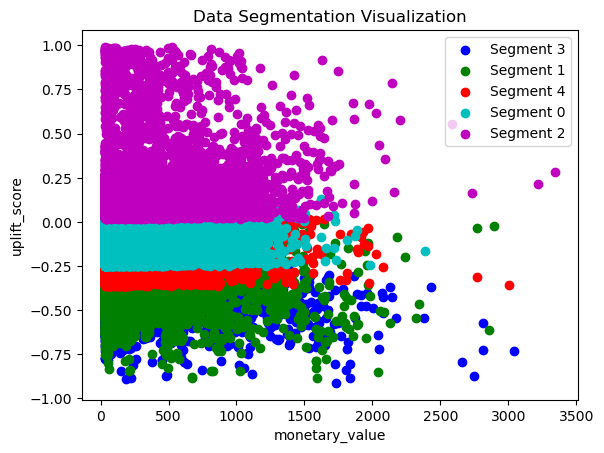

In [74]:
# Select columns for visualization
x_column = 'monetary_value'
y_column = 'uplift_score'

# Define colors for each segment
colors = ['b', 'g', 'r', 'c', 'm']

# Plot the entire dataset with segments highlighted
for segment, color in zip(df_sorted['Clustering_Segment'].unique(), colors):
    plt.scatter(df_sorted[df_sorted['Clustering_Segment'] == segment][x_column], df_sorted[df_sorted['Clustering_Segment'] == segment][y_column], c=color, label=f'Segment {segment}')

# Set plot labels and title
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.title('Data Segmentation Visualization')
plt.legend()
plt.show()